In [76]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from traj_helpers import get_trajectories, normalize_trajectory, resample_trajectory, plot_trajectory
from traj_dataset import TrajDataset
from autoencoders import MLP_VAE
from loss import traj_mse_loss, kl_loss
import numpy as np

TRAINING_DIRS = ['mocap_dataset/strokes']
FINETUNE_DIRS = ['mocap_dataset/long']
DRAWING_DIRS = TRAINING_DIRS + FINETUNE_DIRS
LATENT_DIM = 64
POINTS_PER_TRAJ = 32
BETA = 0.000001

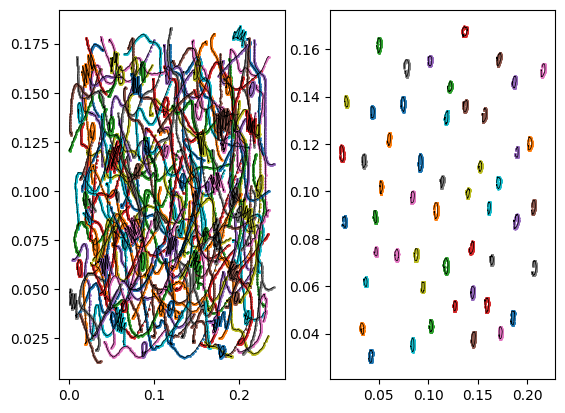

In [72]:
# Plot all the paintings
fig, axs = plt.subplots(1, len(DRAWING_DIRS), squeeze=False)
for (i, dir) in enumerate(DRAWING_DIRS):
    trajectories = get_trajectories([dir])

    for traj in trajectories:
        plot_trajectory(axs[0][i], traj)

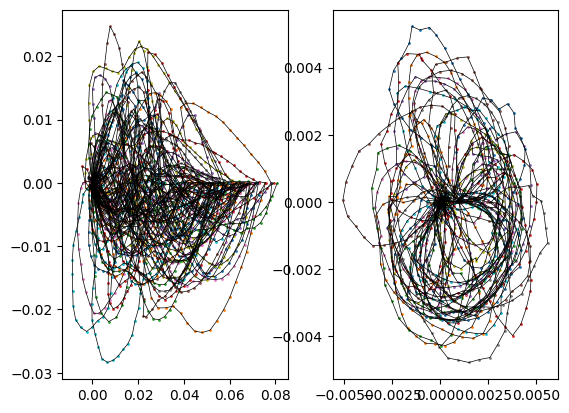

In [73]:
training_trajectories = get_trajectories(TRAINING_DIRS)
finetune_trajectories = get_trajectories(FINETUNE_DIRS)

def filter_trajectories(trajectories):
    # Filter out trajectories that zigzag too much
    filtered_trajectories = []
    for trajectory in trajectories:
        zigzag_score = 0
        cur_angle = -1
        for j in range(1, len(trajectory)):
            angle = np.arctan2(trajectory[j][1] - trajectory[j-1][1], trajectory[j][0] - trajectory[j-1][0])
            length = np.linalg.norm(trajectory[j] - trajectory[j-1])
            if cur_angle == -1:
                cur_angle = angle
            else:
                angle_diff = abs(angle - cur_angle) % (2 * np.pi)
                angle_diff = min(angle_diff, 2 * np.pi - angle_diff)
                zigzag_score += angle_diff * length
                cur_angle = angle
        # if zigzag_score < 0.02:
        if zigzag_score < 100 and len(trajectory) >= 2:
            filtered_trajectories.append(trajectory)
    return filtered_trajectories

training_trajectories = filter_trajectories(training_trajectories)
finetune_trajectories = filter_trajectories(finetune_trajectories)

for i in range(len(training_trajectories)):
    training_trajectories[i] = normalize_trajectory(training_trajectories[i])
    training_trajectories[i] = resample_trajectory(training_trajectories[i], num_points=POINTS_PER_TRAJ)

for i in range(len(finetune_trajectories)):
    finetune_trajectories[i] = normalize_trajectory(finetune_trajectories[i])
    finetune_trajectories[i] = resample_trajectory(finetune_trajectories[i], num_points=POINTS_PER_TRAJ)

fig, axs = plt.subplots(1, 2)
idx = 0
cnt = 100
for trajectory in training_trajectories[idx:idx+cnt]:
    plot_trajectory(axs[0], trajectory)
for trajectory in finetune_trajectories[idx:idx+cnt]:
    plot_trajectory(axs[1], trajectory)

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP_VAE(
    input_points_per_traj=POINTS_PER_TRAJ,
    latent_dim=LATENT_DIM,
    output_points_per_traj=POINTS_PER_TRAJ
)
model.to(device)

def train(model, trajectories, epochs, lr):
    dataset = TrajDataset(trajectories)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output, mean, logvar = model(batch)
            mse = traj_mse_loss(batch, output)
            kl = kl_loss(mean, logvar)
            loss = mse + BETA * kl
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(epoch, loss.item())

train(model, training_trajectories, 1000, 0.001)
train(model, finetune_trajectories, 100, 0.001)

0 0.00017359587945975363
10 4.365557833807543e-05
20 2.9292723411344923e-05
30 4.056501347804442e-05
40 2.8240992833161727e-05
50 3.5080956877209246e-05
60 1.48665567394346e-05
70 1.3628679880639538e-05
80 1.9070446796831675e-05
90 2.3903154215076938e-05
100 2.0885447156615555e-05
110 1.9226074073230848e-05
120 2.4233399017248303e-05
130 2.853364458133001e-05
140 2.0016334019601345e-05
150 1.842638084781356e-05
160 1.6153344404301606e-05
170 1.69924387591891e-05
180 2.6629868443706073e-05
190 1.786799111869186e-05
200 2.3844688257668167e-05
210 2.053230127785355e-05
220 1.510824222350493e-05
230 1.9038436221308075e-05
240 1.4437131540034898e-05
250 1.1948259270866401e-05
260 2.2590127628063783e-05
270 1.4565004676114768e-05
280 1.2295242413529195e-05
290 1.6815389244584367e-05
300 1.5197694665403105e-05
310 1.7040005332091823e-05
320 9.181920177070424e-06
330 1.1537848877196666e-05
340 6.742059667885769e-06
350 1.007313039735891e-05
360 9.334838068753015e-06
370 1.2843305739806965e-05


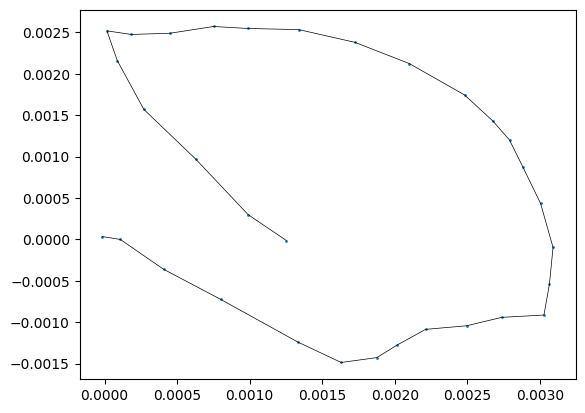

In [110]:
# Visualize generated trajectories
generated_trajectories = model.sample_trajectories(100)
fig, ax = plt.subplots()
idx = 0
cnt = 1
for trajectory in generated_trajectories[idx:idx+cnt]:
    plot_trajectory(ax, trajectory)